In [1]:
from typing import Optional, Dict, Any
import numpy as np
from filelock import FileLock
import pathlib
import pandas as pd
from itertools import product

import os
os.chdir("C:/Users/liuch/Dropbox (Personal)/MIT Pre-Doc Personal/Rahul Singh/Debiased Kernel Methods/Alternative Riesz Representer/KernelCausalFunction")
from src.cate.data.data_class import CATETrainDataSet, CATETestDataSet
from src.utils.kernel_func import AbsKernel, GaussianKernel, BinaryKernel
from src.utils import cal_loocv, cal_loocv_emb, cal_loocv_with_cluster

from matplotlib import pyplot

c:\Users\liuch\miniconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\liuch\AppData\Local\Temp\ipykernel_8572\1280097207.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Binarized Treatment

In [2]:
def get_kernel_func(data_name: str) -> [AbsKernel, AbsKernel, AbsKernel]:
    if data_name == "job_corp":
        return GaussianKernel(), BinaryKernel(), GaussianKernel()
    elif data_name == "synthetic":
        return GaussianKernel(), BinaryKernel(), GaussianKernel()
    else:
        return GaussianKernel(), GaussianKernel(), GaussianKernel()


class BackDoorMeanEmbedding:
    treatment_kernel_func: AbsKernel
    covariate_kernel_func: AbsKernel
    train_treatment: np.ndarray
    train_covariate: np.ndarray
    kernel_mat: np.ndarray
    cov_kernel_mat: np.ndarray
    backdoor_kernel: np.ndarray
    outcome: np.ndarray

    def __init__(self, lam1, lam2, **kwargs):
        self.lam1 = lam1
        self.lam2 = lam2

    def fit(self, train_data: CATETrainDataSet, data_name: str):
        self.train_treatment = np.array(train_data.treatment, copy=True)
        self.outcome = np.array(train_data.outcome, copy=True)
        self.train_covariate = np.array(train_data.covariate, copy=True)

        funcs = get_kernel_func(data_name)
        backdoor_kernel_func = funcs[0]
        self.treatment_kernel_func = funcs[1]
        self.covariate_kernel_func = funcs[2]

        backdoor_kernel_func.fit(train_data.backdoor, )
        self.treatment_kernel_func.fit(train_data.treatment, )
        self.covariate_kernel_func.fit(train_data.covariate, )

        treatment_kernel = self.treatment_kernel_func.cal_kernel_mat(train_data.treatment, train_data.treatment)
        self.backdoor_kernel = backdoor_kernel_func.cal_kernel_mat(train_data.backdoor, train_data.backdoor)
        covariate_kernel = self.covariate_kernel_func.cal_kernel_mat(train_data.covariate, train_data.covariate)

        all_kernel_mat = covariate_kernel * treatment_kernel * self.backdoor_kernel
        if isinstance(self.lam1, list):
            score = [cal_loocv(all_kernel_mat, self.outcome, reg) for reg in self.lam1]
            self.lam1 = self.lam1[np.argmin(score)]
            print(self.lam1)

        if isinstance(self.lam2, list):
            score = [cal_loocv_emb(covariate_kernel, self.backdoor_kernel, reg) for reg in self.lam2]
            self.lam2 = self.lam2[np.argmin(score)]
            print(self.lam2)

        n_data = treatment_kernel.shape[0]
        self.kernel_mat = (all_kernel_mat + n_data * self.lam1 * np.eye(n_data))
        self.cov_kernel_mat = covariate_kernel + n_data * self.lam2 * np.eye(n_data)

    def predict(self, treatment: np.ndarray, covariate: np.ndarray) -> np.ndarray:
        treatment_kernel = self.treatment_kernel_func.cal_kernel_mat(self.train_treatment, treatment)
        cov_kernel = self.covariate_kernel_func.cal_kernel_mat(self.train_covariate, covariate)
        test_kernel = np.linalg.solve(self.cov_kernel_mat, cov_kernel)
        test_kernel = np.dot(self.backdoor_kernel, test_kernel)
        test_kernel = test_kernel * cov_kernel * treatment_kernel
        mat = np.linalg.solve(self.kernel_mat, test_kernel)
        return np.dot(mat.T, self.outcome)

    def evaluate(self, test_data: CATETestDataSet):
        pred = self.predict(treatment=test_data.treatment, covariate=test_data.covariate)
        return np.mean((pred - test_data.structural) ** 2)


def evaluate_mean_embedding(data_config: Dict[str, Any], model_param: Dict[str, Any]):
    train_data = generate_train_data()
    test_data = generate_test_data()
    model = BackDoorMeanEmbedding(**model_param)
    model.fit(train_data, data_config["name"])
    if test_data.structural is not None:
        return model.evaluate(test_data)
    else:
        return model.predict(test_data.treatment, test_data.covariate)[:, 0]

def generate_test_data():
    treatment = np.arange(0, 2)
    covariate = test_data_wrapper()
    data = np.array(list(product(treatment, covariate)))
    return CATETestDataSet(treatment=data[:, [0]],
                           covariate=data[:, [1]],
                           structural=None)

def run_test(lam1, lam2):
    env_param = {
        "name": "job_corp",
        "split_type": 3
    }
    mdl_param = {
        "name": "mean_embedding",
        "lam1": lam1,
        "lam2": lam2
    }
    return evaluate_mean_embedding(env_param, mdl_param)

In [3]:
def get_data(data):
    if data == '401k':

        abtest = False
        file = "https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv"
        data = pd.read_csv(file)
        y = data['net_tfa'].values
        D = data['e401'].values
        X = data.drop(['e401', 'p401', 'a401', 'tw', 'tfa', 'net_tfa', 'tfa_he',
                        'hval', 'hmort', 'hequity',
                        'nifa', 'net_nifa', 'net_n401', 'ira',
                        'dum91', 'icat', 'ecat', 'zhat',
                        'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7',
                        'a1', 'a2', 'a3', 'a4', 'a5'], axis=1)
        
        mask = (X['inc'] > 0) & (X['inc'] >= np.percentile(X['inc'], 1))
        mask &= (X['inc'] <= np.percentile(X['inc'], 99))
        X, D, y = X[mask], D[mask], y[mask]
        groups = None

    elif data == 'criteo':
        
        abtest = True
        df = pd.read_csv('C:/Users/liuch/Documents/large_datasets/criteo-uplift-v2.1.csv')
        y = df['visit'].values
        D = df['treatment'].values
        X = df.drop(['treatment', 'conversion', 'visit', 'exposure'], axis=1)
        groups = None

    elif data == 'welfare':

        abtest = True
        
        df = pd.read_csv('C:/Users/liuch/Documents/large_datasets/welfarenolabel3.csv', na_values=-999)
        continuous = ['hrs1', 'income', 'rincome', 'age', 'polviews',
                    'educ', 'earnrs', 'sibs', 'childs', 'occ80', 'prestg80', 'indus80',
                    'res16', 'reg16', 'family16', 'parborn', 'maeduc', 'degree', 
                    'hompop', 'babies', 'preteen', 'teens', 'adults']
        categorical = ['partyid', 'wrkstat', 'wrkslf', 'marital', 'race', 'mobile16', 'sex', 'born']
        df = df[['y', 'w'] + continuous + categorical]
        df = df.dropna()
        df = df[~((df['polviews']>4) & (df['polviews'] < 5))]
        df = pd.get_dummies(df, columns=categorical, drop_first=True)
        
        y = df['y'].values
        D = df['w'].values
        X = df.drop(['y', 'w'], axis=1)
        groups = None
    
    elif data == 'poverty':

        abtest = True
        df = pd.read_csv('https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/Poverty/carvalho2016.csv', na_values=-999)
        df = df.dropna()
        y = df['outcome.correct.ans.per.second'].values
        D = df['treatment'].values
        X = df.drop(["outcome.correct.ans.per.second","outcome.num.correct.ans",
                     'outcome.response.time', 'treatment'], axis=1)
        groups = None

    elif data == 'charitable':

        abtest = True
        df = pd.read_csv('https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/Charitable/ProcessedData/charitable_withdummyvariables.csv', na_values=-999)
        df = df.loc[df['treat_ratio2']!=1]
        df = df.loc[df['treat_ratio3']!=1]
        df = df.drop(['treat_ratio2', 'treat_ratio3', 'treat_size25', 'treat_size50',
                     'treat_size100', 'treat_sizeno', 'treat_askd1', 'treat_askd2', 'treat_askd3',
                     'out_amountgive', 'out_changeamtgive'], axis=1)
        df = df.dropna()
        y = df['out_gavedum'].values
        D = df['treatment'].values
        X = df.drop(['treatment', 'out_gavedum'], axis=1)
        groups = None
    
    elif data == 'star':

        abtest = True
        URL = 'https://raw.githubusercontent.com/gsbDBI/ExperimentData/master/Project%20STAR/STAR_Students.tab'
        df = pd.read_csv(URL, delimiter='\t')
        Xcols = ['gender', 'race', 'birthmonth', 'birthyear',
                'gkschid', 'gksurban', 'gktgen',
                'gktrace', 'gkthighdegree', 'gktcareer',
                'gktyears', 'gkfreelunch', 'gkrepeat',
                'gkspeced', 'gkspecin']
        Dcols = ['gkclasstype']
        ycols = ['gktreadss', 'gktmathss']
        Gcols = ['gktchid']
        df = df[Xcols + Dcols + ycols + Gcols]
        df = df.dropna()
        y = np.sum(df[ycols].values, axis=1) # total of reading and math scores
        D = 1.0 * (df[Dcols].values.flatten() == 1) # is small class
        X = df[Xcols]
        groups = df[Gcols[0]].values

    else:
        raise AttributeError("Dataset name is invalid!")
    
    return X, D, y, groups

In [4]:
## All datasets have binary treatment.
# dataset_name = "401k"  # age column 0
# dataset_name = "criteo"  # ???
# dataset_name = "welfare"  # age column 3
dataset_name = "poverty"  # age column 6
# dataset_name = "star"  # birth month column 2
X, D, y, groups = get_data(dataset_name)

outcome = y
treatment = D
covariate = X["current.income"].to_numpy()
backdoor = X.drop("current.income", axis=1).to_numpy()

print(covariate.min())
print(covariate.max())

1
15536


(array([1298.,  986.,  140.,   27.,   11.,    4.,    4.,    4.,    3.,
           3.]),
 array([1.00000e+00, 1.55450e+03, 3.10800e+03, 4.66150e+03, 6.21500e+03,
        7.76850e+03, 9.32200e+03, 1.08755e+04, 1.24290e+04, 1.39825e+04,
        1.55360e+04]),
 <BarContainer object of 10 artists>)

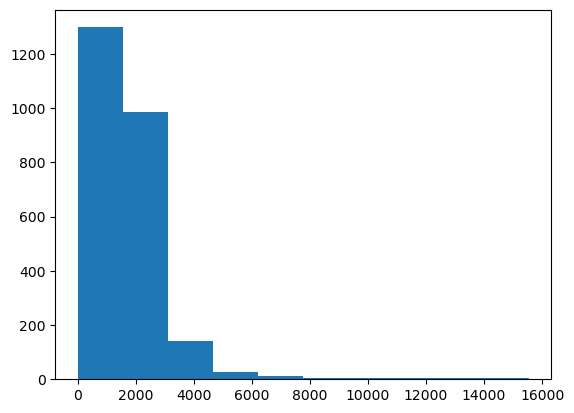

In [5]:
import matplotlib.pyplot as plt

plt.hist(covariate)

401k data | Covariate: age 25-64

In [6]:
def generate_train_data():
    dataset_name = "401k"
    X, D, y, groups = get_data(dataset_name)

    outcome = y
    treatment = D
    covariate = X.iloc[:, 0].to_numpy()
    backdoor = X.iloc[:, 1:].to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def test_data_wrapper():
    return np.linspace(25, 64, 391)

0.001
0.0005


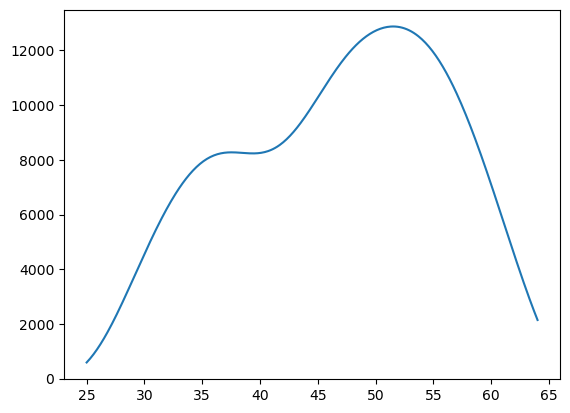

In [15]:
outcome = run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
                   lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

effect = outcome[391:782] - outcome[0:391]
pyplot.plot(np.linspace(25, 64, 391), effect)

Welfare data | Covariate: age 18-88

In [ ]:
# WARNING: D seems to be the wrong round.
def generate_train_data():
    dataset_name = "welfare"
    X, D, y, groups = get_data(dataset_name)
    X.replace({False: 0, True: 1}, inplace=True)
    
    outcome = y
    treatment = D
    covariate = X["age"].to_numpy()
    backdoor = X.drop("age", axis=1).to_numpy()

    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def test_data_wrapper():
    return np.linspace(18, 88, 701)

outcome = run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
                   lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

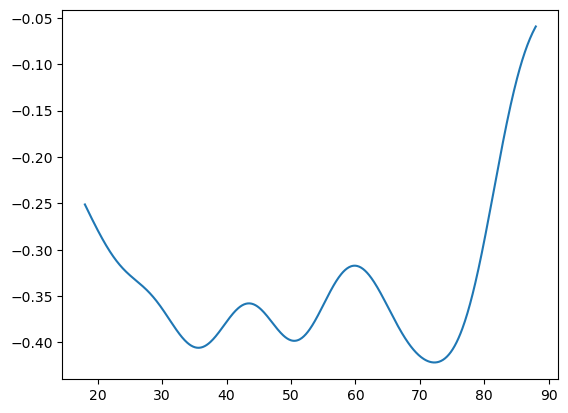

In [ ]:
effect = outcome[701:1402] - outcome[0:701]
pyplot.plot(np.linspace(18, 88, 701), effect)

In [ ]:
def generate_train_data():
    dataset_name = "welfare"
    X, D, y, groups = get_data(dataset_name)
    X.replace({False: 0, True: 1}, inplace=True)
    
    outcome = y
    treatment = D
    covariate = X["age"].to_numpy()
    backdoor = X.drop("age", axis=1).to_numpy()

    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def test_data_wrapper():
    return np.linspace(18, 88, 701)

outcome = run_test(lam1 = 0.001,
                   lam2 = 0.001)

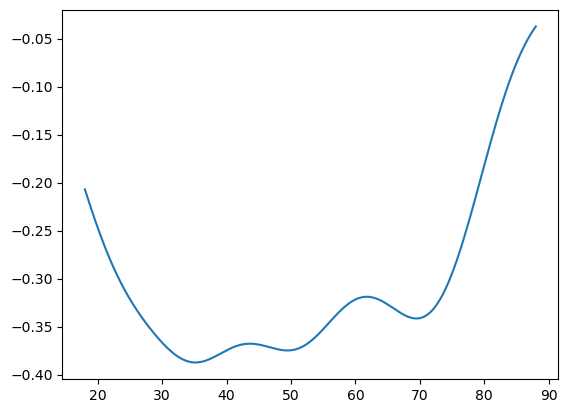

In [ ]:
effect = outcome[701:1402] - outcome[0:701]
pyplot.plot(np.linspace(18, 88, 701), effect)

Poverty data | Covariate: age 18-93

In [37]:
def generate_train_data():
    dataset_name = "poverty"
    X, D, y, groups = get_data(dataset_name)

    outcome = y
    treatment = D
    covariate = X["current.income"].to_numpy()
    backdoor = X.drop("current.income", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def test_data_wrapper():
    return np.linspace(1, 15536, 100)

outcome = run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
                   lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

0.0001
0.001


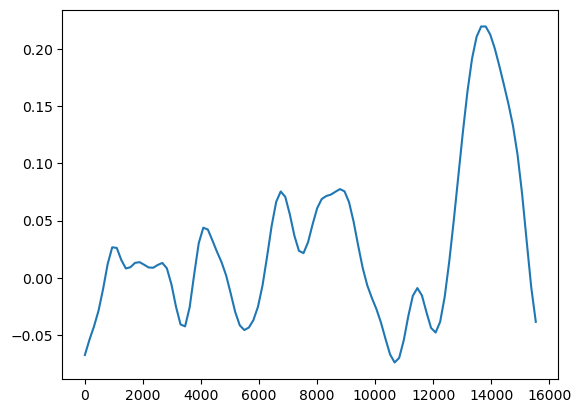

In [38]:
effect = outcome[100:200] - outcome[0:100]
pyplot.plot(np.linspace(1, 15536, 100), effect)

In [49]:
def generate_train_data():
    dataset_name = "poverty"
    X, D, y, groups = get_data(dataset_name)

    outcome = y
    treatment = D
    covariate = X["current.income"].to_numpy()
    backdoor = X.drop("current.income", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def test_data_wrapper():
    return np.linspace(1, 15536, 100)

outcome = run_test(lam1 = 0.01,
                   lam2 = 0.01)

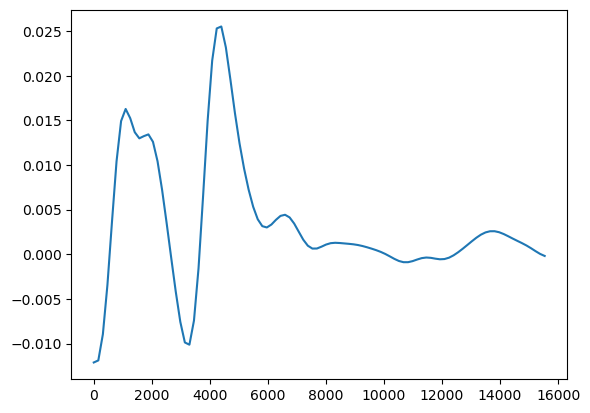

In [50]:
effect = outcome[100:200] - outcome[0:100]
pyplot.plot(np.linspace(1, 15536, 100), effect)

STAR data | Covariate: birth month 1-12

In [55]:
def generate_train_data():
    dataset_name = "star"
    X, D, y, groups = get_data(dataset_name)

    outcome = y
    treatment = D
    covariate = X["birthmonth"].to_numpy()
    backdoor = X.drop("birthmonth", axis=1).to_numpy()
    return CATETrainDataSet(backdoor=backdoor,
                            outcome=outcome[:, np.newaxis],
                            treatment=treatment[:, np.newaxis],
                            covariate=covariate[:, np.newaxis])

def test_data_wrapper():
    return np.linspace(1, 12, 12)

outcome = run_test(lam1 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
                   lam2 = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005])

5e-05
0.001


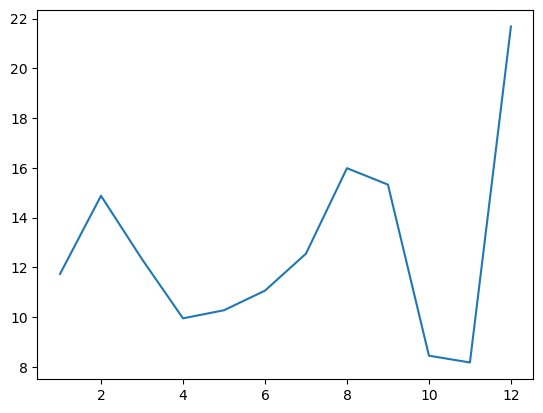

In [56]:
effect = outcome[12:24] - outcome[0:12]
pyplot.plot(np.linspace(1, 12, 12), effect)